<p style="font-family: Cambria; text-align: center; font-size: 48px;"> II. Predictive  Analysis</p>

In [16]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, roc_curve
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# ---------------------------------------------------------
# STEP 0 – LOAD DATA
# ---------------------------------------------------------
df = pd.read_csv("covid_python_Dec25.csv",low_memory=False)


<b style="font-family: Cambria; font-size: 16px;"><i><b>Predictive Question:</b></i></b>
<b style="font-family: Cambria; font-size: 16px;">Which patients are most likely to experience severe COVID‑related outcomes (such as hospitalization or high‑severity symptoms), based on demographics, comorbidities, and symptom presentation?</b>

<br>

<b style="font-family: Cambria; font-size: 16px;"><i><b>Specific Predictive Hypotheses:</b></i></b>

<b style="font-family: Cambria; font-size: 16px;"><i><b>1. Age–Risk Hypothesis:</b></i></b>
<b style="font-family: Cambria; font-size: 16px;">Older adults (e.g., ≥65 years) have a higher probability of experiencing severe COVID‑19 outcomes than younger individuals.</b>

<b style="font-family: Cambria; font-size: 16px;"><i><b>2. Comorbidity–Risk Hypothesis:</b></i></b>
<b style="font-family: Cambria; font-size: 16px;">Patients with a greater number of comorbidities are more likely to develop severe outcomes compared to those with few or no comorbidities.</b>

<b style="font-family: Cambria; font-size: 16px;"><i><b>3. Symptom–Risk Hypothesis:</b></i></b>
<b style="font-family: Cambria; font-size: 16px;">Patients reporting moderate to severe symptoms (e.g., dyspnea, chest pain, persistent fever) have a higher likelihood of hospitalization or clinical deterioration.</b>

<b style="font-family: Cambria; font-size: 16px;"><i><b>4. Combined‑Risk (Marker Group) Hypothesis:</b></i></b>
<b style="font-family: Cambria; font-size: 16px;">Certain marker groups — such as “65+ with ≥2 comorbidities and high symptom severity” — will exhibit significantly elevated risk and should be prioritized for early intervention.</b>

In [17]:

print("Data shape:", df.shape)
print(df.head())

# Filter out NR age categories
df_clean = df[df['age_category'] != 'NR']

# Total persons per age category
age_total = (
    df_clean.groupby('age_category')
      .size()
      .reset_index(name='total_persons')
)
def count_symptoms(val):
    if pd.isna(val) or str(val).strip() == "" or str(val).upper() == "NR":
        return 0
    
    # split on ";" and remove blanks
    parts = [x.strip() for x in str(val).split(";") if x.strip() != ""]
    return len(parts)
df["symptom_count"] = df["symptoms"].apply(count_symptoms)
def severity_level(c):
    if c == 0:
        return 0          # none
    elif c == 1:
        return 1          # mild
    elif c <= 3:
        return 2          # moderate (2–3 symptoms)
    else:
        return 3          # severe (>3)
df["symptom_severity"] = df["symptom_count"].apply(severity_level)  
 
# 1.2 COVID positive flag
df['self_isolating_flag'] = (
    df['self_isolating']
      .astype(str).str.lower()
      .apply(lambda x: 1 if x in ['y'] else 0)
)
df["hospitalized"] = 0

df.loc[
    (df["self_isolating_flag"] == 0) &
    (df["symptom_severity"] > 2),
    "hospitalized"
] = 1

Data shape: (294105, 32)
   week  fsa probable vulnerable is_most_recent fever_chills_shakes cough  \
0  13.0  L4C        n          n              y                   n     n   
1  13.0  P1H        y          y              y                   n     n   
2  14.0  N2J        n          y              y                   n     n   
3  13.0  N1G        n          n              y                   n     n   
4  13.0  M1P        n          y              n                   n     n   

  shortness_of_breath over_60 any_medical_conditions  ... covid_positive  \
0                   n       n                      n  ...             NR   
1                   n       y                      y  ...             NR   
2                   n       y                      n  ...             NR   
3                   n       n                      n  ...             NR   
4                   n       n                      y  ...             NR   

  mental_health_impact travel_work_school self_isolatin

In [18]:
# 1.2 COVID positive flag
df['covid_positive_flag'] = (
    df['covid_positive']
      .astype(str).str.lower()
      .apply(lambda x: 1 if x in ['positively'] else 0)
)
print(df["covid_positive_flag"].unique())

[0 1]


In [20]:
# 1.3 Vulnerable flag
if 'vulnerable' in df.columns:
    df['vulnerable_flag'] = (
        df['vulnerable']
          .astype(str).str.lower()
          .apply(lambda x: 1 if x in ['y', 'yes', '1', 'true'] else 0)
    )
else:
    df['vulnerable_flag'] = 0


In [21]:
# 1.4 Comorbidity count
def count_comorbidities(x):
    if pd.isna(x):
        return 0
    s = str(x).strip().lower()
    if s in ["not reported", "none", "nr", "no", ""]:
        return 0
    return len([c for c in s.split(',') if c.strip()])

df['comorbidities_count'] = df['conditions'].apply(count_comorbidities)
print(df["comorbidities_count"].unique())

[0 1]


In [22]:
df['severe_outcome_flag'] = np.where(
    (df['hospitalized'] == 1) |
   ((df['covid_positive_flag'] == 1) & (df['symptom_severity'] >= 2)),
    1, 0
)
print(df["severe_outcome_flag"].unique())

[0 1]


In [23]:


# 1.6 Needs cleaned (optional as predictor)
# ---------------------------------------------------------
# STEP 1 – DERIVE FEATURES
# ---------------------------------------------------------
# 1.6 Needs cleaned (optional as predictor)
invalid_needs = ["nr", "noneoftheabove", "other", "none", "not reported"]
df['needs_clean'] = df['needs'].astype(str).str.lower().str.strip()
df['needs_clean'] = df['needs_clean'].where(~df['needs_clean'].isin(invalid_needs), 'unknown')

# Drop rows with missing key predictors if needed
df_model = df.dropna(subset=['age_category', 'sex', 'fsa'])

# ---------------------------------------------------------
# STEP 2 – DEFINE FEATURES & TARGET
# ---------------------------------------------------------
feature_cols = [
    'sex',
    'fsa',
    'age_category',
    'comorbidities_count',
    'symptom_severity',
    'vulnerable_flag',
    'covid_positive_flag',
    'needs_clean'
]

X = df_model[feature_cols].copy()
y = df_model['severe_outcome_flag'].values

numeric_features = [
    'comorbidities_count',
    'symptom_severity',
    'vulnerable_flag',
    'covid_positive_flag'
]

categorical_features = [
    'sex',
    'fsa',
    'age_category',
    'needs_clean'
]

# ---------------------------------------------------------
# STEP 3 – PREPROCESSING PIPELINE
# ---------------------------------------------------------
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# ---------------------------------------------------------
# STEP 4 – TRAIN/TEST SPLIT
# ---------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# ---------------------------------------------------------
# STEP 5 – BASELINE MODEL: LOGISTIC REGRESSION
# ---------------------------------------------------------
log_reg_clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LogisticRegression(max_iter=1000))
])

log_reg_clf.fit(X_train, y_train)
y_pred_proba_lr = log_reg_clf.predict_proba(X_test)[:, 1]
y_pred_lr = (y_pred_proba_lr >= 0.5).astype(int)

print("\n=== Logistic Regression ===")
print("AUC:", roc_auc_score(y_test, y_pred_proba_lr))
print("\nClassification report:\n", classification_report(y_test, y_pred_lr))


=== Logistic Regression ===
AUC: 0.9999274346445652

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     88173
           1       0.75      0.90      0.82        59

    accuracy                           1.00     88232
   macro avg       0.87      0.95      0.91     88232
weighted avg       1.00      1.00      1.00     88232



In [8]:
# ---------------------------------------------------------
# STEP 6 – ADVANCED MODEL: XGBOOST
# ---------------------------------------------------------
xgb_clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', XGBClassifier(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1
    ))
])

xgb_clf.fit(X_train, y_train)
y_pred_proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]
y_pred_xgb = (y_pred_proba_xgb >= 0.5).astype(int)

print("\n=== XGBoost ===")
print("AUC:", roc_auc_score(y_test, y_pred_proba_xgb))
print("\nClassification report:\n", classification_report(y_test, y_pred_xgb))



=== XGBoost ===
AUC: 0.9999001385373554

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     88173
           1       0.72      0.85      0.78        59

    accuracy                           1.00     88232
   macro avg       0.86      0.92      0.89     88232
weighted avg       1.00      1.00      1.00     88232



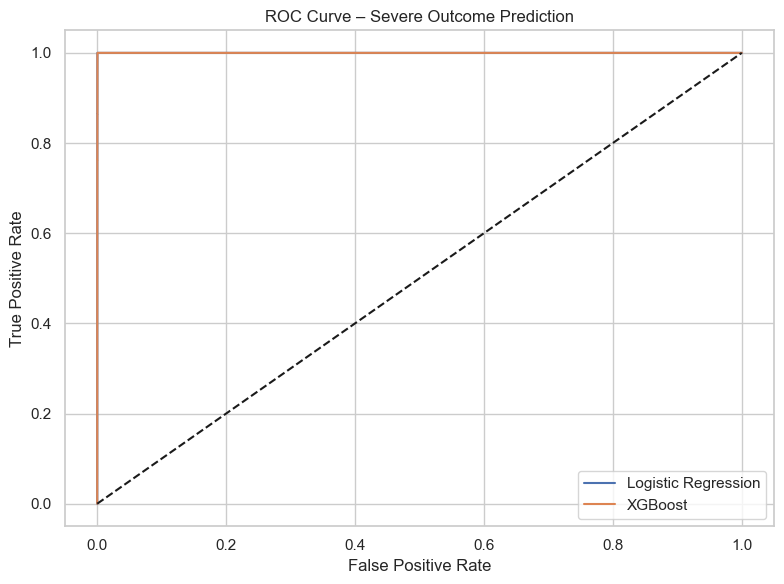

In [24]:
# ---------------------------------------------------------
# STEP 7 – ROC CURVE
# ---------------------------------------------------------
from sklearn.metrics import roc_curve

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Severe Outcome Prediction')
plt.legend()
plt.tight_layout()
plt.show()


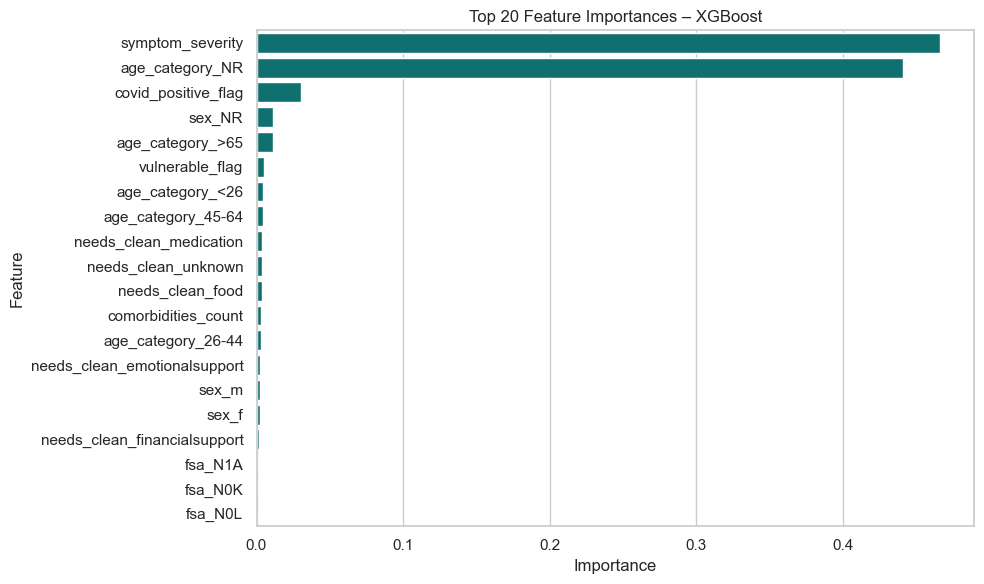


Top feature importances:
                           feature  importance
1                symptom_severity    0.466346
527               age_category_NR    0.440945
3             covid_positive_flag    0.030674
4                          sex_NR    0.011299
526              age_category_>65    0.010928
2                 vulnerable_flag    0.005293
525              age_category_<26    0.004353
524            age_category_45-64    0.004209
531        needs_clean_medication    0.003960
532           needs_clean_unknown    0.003678
530              needs_clean_food    0.003560
0             comorbidities_count    0.003077
523            age_category_26-44    0.002876
528  needs_clean_emotionalsupport    0.002378
6                           sex_m    0.002352
5                           sex_f    0.002203
529  needs_clean_financialsupport    0.001870
361                       fsa_N1A    0.000000
355                       fsa_N0K    0.000000
356                       fsa_N0L    0.000000


In [10]:
# ---------------------------------------------------------
# STEP 8 – FEATURE IMPORTANCE (XGBoost)
# ---------------------------------------------------------
xgb_model = xgb_clf.named_steps['model']
ohe = xgb_clf.named_steps['preprocess'].named_transformers_['cat'].named_steps['onehot']
cat_feature_names = list(ohe.get_feature_names_out(categorical_features))
all_feature_names = numeric_features + cat_feature_names

importances = xgb_model.feature_importances_
feat_imp = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
}).sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp, x='importance', y='feature', color='teal')
plt.title('Top 20 Feature Importances – XGBoost')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("\nTop feature importances:\n", feat_imp)



=== Marker Groups (Age × Comorbidity) ===
   age_category comorbidity_group  patient_count  severe_cases  mean_risk  \
9           <26                 1            333            12   0.037192   
1         26-44                 1           1684            19   0.012928   
5         45-64                 1           2829            34   0.011780   
13          >65                 1           1311            13   0.009546   
8           <26                 0           2902            25   0.009375   
0         26-44                 0          10402            54   0.005122   
4         45-64                 0           8942            37   0.003856   
12          >65                 0           2063             1   0.000440   
16           NR                 0         263639             0   0.000002   
2         26-44               2-3              0             0        NaN   
3         26-44                4+              0             0        NaN   
6         45-64               2-3

C:\Users\vukch\AppData\Local\Temp\ipykernel_37068\2992027245.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_model.groupby(['age_category', 'comorbidity_group'])


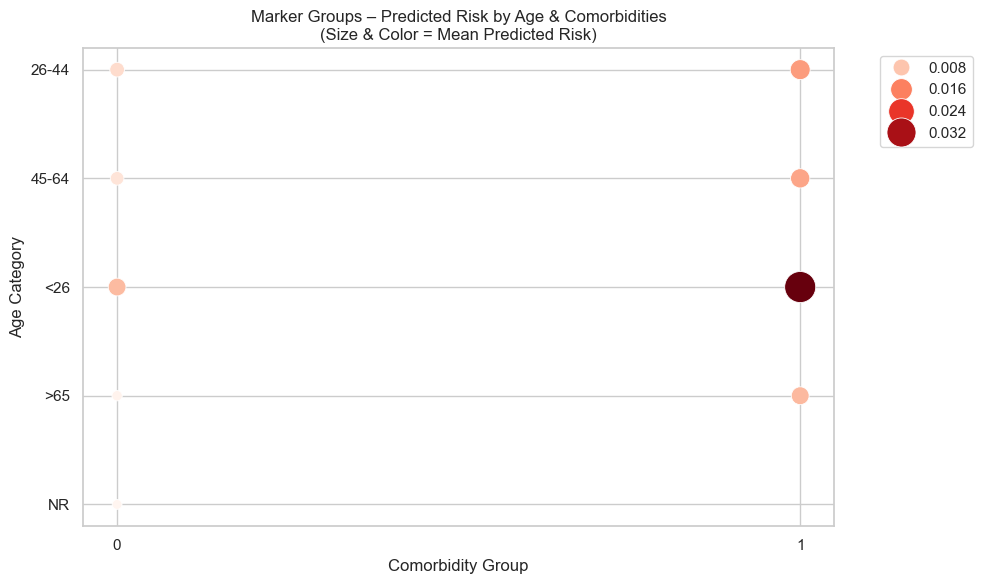

In [25]:

# ---------------------------------------------------------
# STEP 9 – MARKER GROUPS: AGE × COMORBIDITIES
# ---------------------------------------------------------
df_model['predicted_risk'] = xgb_clf.predict_proba(X)[:, 1]

df_model['comorbidity_group'] = pd.cut(
    df_model['comorbidities_count'],
    bins=[-1, 0, 1, 3, 100],
    labels=['0', '1', '2-3', '4+']
)

marker_group_summary = (
    df_model.groupby(['age_category', 'comorbidity_group'])
      .agg(
          patient_count=('severe_outcome_flag', 'count'),
          severe_cases=('severe_outcome_flag', 'sum'),
          mean_risk=('predicted_risk', 'mean')
      )
      .reset_index()
)

marker_group_summary['severe_rate'] = (
    marker_group_summary['severe_cases'] / marker_group_summary['patient_count']
)

print("\n=== Marker Groups (Age × Comorbidity) ===")
print(marker_group_summary.sort_values('mean_risk', ascending=False).head(15))

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=marker_group_summary,
    x='comorbidity_group',
    y='age_category',
    size='mean_risk',
    hue='mean_risk',
    sizes=(50, 500),
    palette='Reds'
)
plt.title('Marker Groups – Predicted Risk by Age & Comorbidities\n(Size & Color = Mean Predicted Risk)')
plt.xlabel('Comorbidity Group')
plt.ylabel('Age Category')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



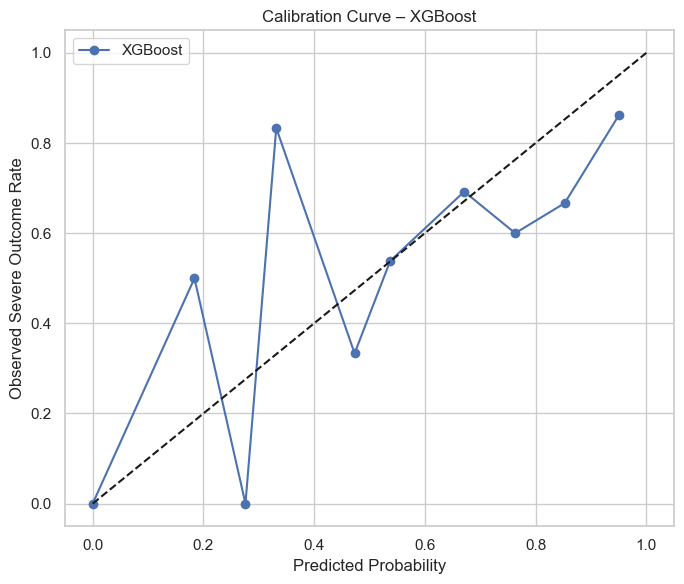

In [12]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, y_pred_proba_xgb, n_bins=10)

plt.figure(figsize=(7,6))
plt.plot(prob_pred, prob_true, marker='o', label='XGBoost')
plt.plot([0,1],[0,1],'k--')
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Severe Outcome Rate")
plt.title("Calibration Curve – XGBoost")
plt.legend()
plt.tight_layout()
plt.show()
